# Synthetic Data (Poisson-Log-Normal)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy 
import matplotlib.pyplot as plt
import seaborn

import time
import pyro
import pyro.poutine as poutine
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDelta, AutoDiagonalNormal, AutoGuideList
from torch.distributions import constraints
from pyro.infer import Predictive

### Helper functions

In [102]:
def generate_fake_data(X_nl, g, k=1, alpha_scale=1E-2, alpha0_loc=-6.0, alpha0_scale=0.5, noise_scale=1E-2):
    """
    Args:
        X_nl: design matrix (with the covariates)
        g: int, number of genes
        k: int, number of cell types
        alpha_scale: scale for alpha
        alpha0_loc: loc of alpha0
        alpha0_scale: scale for alpha0
        noise_scale: noise scale
    """
    n, l = X_nl.shape[:2]
    cell_ids_n = torch.randint(low=0, high=k, size=[n])
    total_umi_n1 = torch.randint(low=250, high=3000, size=[n,1])
    alpha_klg = alpha_scale * torch.randn((k,l,g))
    alpha0_kg = alpha0_loc + alpha0_scale * torch.randn((k,g))
    eps_g = torch.randn(g) * noise_scale  # std per gene
    eps_ng = torch.randn(n,g) * eps_g
    
    log_mu_ng = alpha0_kg[cell_ids_n] + (X_nl[...,None] * alpha_klg[cell_ids_n]).sum(dim=-2) 
    mu_ng = (log_mu_ng + eps_ng).exp()
    rate_ng = total_umi_n1 * mu_ng
    counts_ng = torch.poisson(rate_ng).long()
    
    results = {
        "cell_type_ids_n": cell_ids_n,
        "counts_ng": counts_ng,
        "alpha0_kg": alpha0_kg,
        "alpha_klg": alpha_klg,
        "X_nl": X_nl
    }
    return results


def plot_few_gene_hist(cell_types_n, counts_ng, other_counts_ng=None, ncols=4):
    assert len(cell_types_n.shape) == 1 
    assert len(counts_ng.shape) == 2
    assert other_counts_ng is None or counts_ng.shape == other_counts_ng.shape
    assert counts_ng.shape[0] == cell_types_n.shape[0]
    
    def _to_torch(_x):
        if isinstance(_x, torch.Tensor):
            return _x
        elif isinstance(_x, numpy.ndarray):
            return torch.tensor(_x)
        else:
            raise Exception("Expected torch.tensor or numpy.ndarray. Received {0}".format(type(_x)))
    
    counts_ng = _to_torch(counts_ng)
    other_counts_ng = None if other_counts_ng is None else _to_torch(other_counts_ng)
    
    ctypes = torch.unique(cell_types_n)
    genes = counts_ng.shape[-1]
    
    
    nrows = genes
    ncols = len(ctypes)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

    for r in range(genes):
        tmp = counts_ng[:,r]
        other_tmp = None if other_counts_ng is None else other_counts_ng[:,r]
        for c, c_type in enumerate(ctypes):
            tmp2 = tmp[cell_types_n == c_type]
            other_tmp2 = None if other_counts_ng is None else other_tmp[cell_types_n == c_type]
            if other_counts_ng is not None:
                barWidth=0.4
                
                y = torch.bincount(tmp2)
                x = torch.arange(y.shape[0]).cpu().numpy()
                other_y = torch.bincount(other_tmp2)
                other_x = torch.arange(other_y.shape[0]).cpu().numpy() + barWidth
                
                _ = axes[r,c].bar(x, y.cpu().numpy(), width = barWidth)
                _ = axes[r,c].bar(other_x, other_y.cpu().numpy(), width = barWidth)
            else:
                y = torch.bincount(tmp2)
                x = numpy.arange(y.shape[0])
                barWidth=0.9
                _ = axes[r,c].bar(x, y, width = barWidth)
    plt.close()
    return fig


def EMD_between_distributions(distA, distB, normalize: bool=False):
    """
    Eearth mover's distance (aka  Wasserstein distance) has a close form solution in 1D.
    See https://en.wikipedia.org/wiki/Wasserstein_metric)
    """

    sizeA = distA.shape[-1]
    sizeB = distB.shape[-1]
    max_size = max(sizeA, sizeB)
    min_size = min(sizeA, sizeB)
    delta_size = max_size - min_size
    
    padder = torch.nn.ConstantPad1d(padding=(0, delta_size), value=0)
    _distA = padder(distA)[...,:max_size]
    _distB = padder(distB)[...,:max_size]
    
    if normalize:
        normA = _distA.sum(dim=-1, keepdim=True)
        normB = _distB.sum(dim=-1, keepdim=True)
        _distA /= normA
        _distB /= normB
    
    # Actual caltulation 
    _distA_cum = torch.cumsum(_distA, axis=-1)
    _distB_cum = torch.cumsum(_distB, axis=-1)    
    EMD = (_distA_cum - _distB_cum).abs().sum(axis=-1)
    return EMD


def L1_between_distributions(distA, distB, normalize: bool=False):
    """ Simple L1 distance between two distributions. """
    sizeA = distA.shape[-1]
    sizeB = distB.shape[-1]
    max_size = max(sizeA, sizeB)
    min_size = min(sizeA, sizeB)
    delta_size = max_size - min_size
    
    padder = torch.nn.ConstantPad1d(padding=(0, delta_size), value=0)
    _distA = padder(distA)[...,:max_size]
    _distB = padder(distB)[...,:max_size]
    
    if normalize:
        normA = _distA.sum(dim=-1, keepdim=True)
        normB = _distB.sum(dim=-1, keepdim=True)
        _distA /= normA
        _distB /= normB
    
    # Actual calculation
    L1_norm = (_distA - _distB).abs().sum(axis=-1)
    return L1_norm


def compute_median_logprob_per_gene_and_cell_type(cell_types_n, log_prob_ng):
    print(log_prob_ng.shape)
    if len(log_prob_ng.shape) == 3:
        log_prob_ng = log_prob_ng.mean(dim=-3)
        print(log_prob_ng.shape)
    assert len(log_prob_ng.shape) == 2
    
    unique_cell_types = torch.unique(cell_types_n)
    k = len(unique_cell_types)
    g = log_prob_ng.shape[-1]
    
    median_kg = torch.zeros((k,g))
    for ik, ctype in enumerate(unique_cell_types):
        log_prob_kg = log_prob_ng[cell_types_n == ctype]
        median_kg[ik] = torch.median(log_prob_kg, axis=-2)[0] 
    return median_kg



def compute_per_cell_type_distributions(cell_types_n, counts_ng):
    """
    Computes the per-cell-type distribution of all the genes
    
    Args:
        cell_types_n: 
        counts_ng:
    
    Returns:
        dist_kgi a tensor of shape (cell_types, genes, max_counts) whose entry represent the number of cells 
        of type k with i counts for gene g.  
    """
    counts_ng = counts_ng.int()
    
    unique_cell_types = torch.unique(cell_types_n)
    i_max = torch.max(counts_ng).item() + 1
    k = len(unique_cell_types)
    g = counts_ng.shape[-1]
    
    dist_kgi = torch.zeros((k,g,i_max))

    for ik, ctype in enumerate(unique_cell_types):
        counts_kg = counts_ng[cell_types_n == ctype]
        for ig in range(g):
            dist_kgi[ik,ig, :] = torch.bincount(counts_kg[:,ig], minlength=i_max) 
    return dist_kgi


def plot_log_prob(cell_types_n, log_prob_ng, other_log_prob_ng=None, ncols=4, bins=20):
    assert len(cell_types_n.shape) == 1 
    assert len(log_prob_ng.shape) == 2
    assert counts_ng.shape[0] == log_prob_ng.shape[0]
    
    def _to_torch(_x):
        if isinstance(_x, torch.Tensor):
            return _x
        elif isinstance(_x, numpy.ndarray):
            return torch.tensor(_x)
        else:
            raise Exception("Expected torch.tensor or numpy.ndarray. Received {0}".format(type(_x)))
    
    log_prob_ng = _to_torch(log_prob_ng)
    ctypes = torch.unique(cell_types_n)
    genes = log_prob_ng.shape[-1]
    
    nrows = genes
    ncols = len(ctypes)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

    for r in range(genes):
        tmp = log_prob_ng[:,r]
        other_tmp = None if other_log_prob_ng is None else other_log_prob_ng[:, r]
        for c, c_type in enumerate(ctypes):
            if other_log_prob_ng is None:
                tmp2 = tmp[cell_types_n == c_type]
                y, x = numpy.histogram(tmp2, bins=bins, density=True)
                barWidth = 0.9 * (x[1]-x[0]) 
                _ = axes[r,c].bar(x[:-1], y, width = barWidth)
            else:
                tmp2 = tmp[cell_types_n == c_type]
                other_tmp2 = other_tmp[cell_types_n == c_type]
                myrange = (min(min(tmp2), min(other_tmp2)).item(), max(max(tmp2), max(other_tmp2)).item())
                y, x = numpy.histogram(tmp2, range=myrange, bins=bins, density=True)
                other_y, other_x = numpy.histogram(other_tmp2, range=myrange, bins=bins, density=True)
                barWidth = 0.4 * (x[1]-x[0]) 
                _ = axes[r,c].bar(x[:-1], y, width = barWidth)
                _ = axes[r,c].bar(other_x[:-1]+barWidth, other_y, width = barWidth)
       
    plt.close()
    return fig

### Generate fake data and visualize

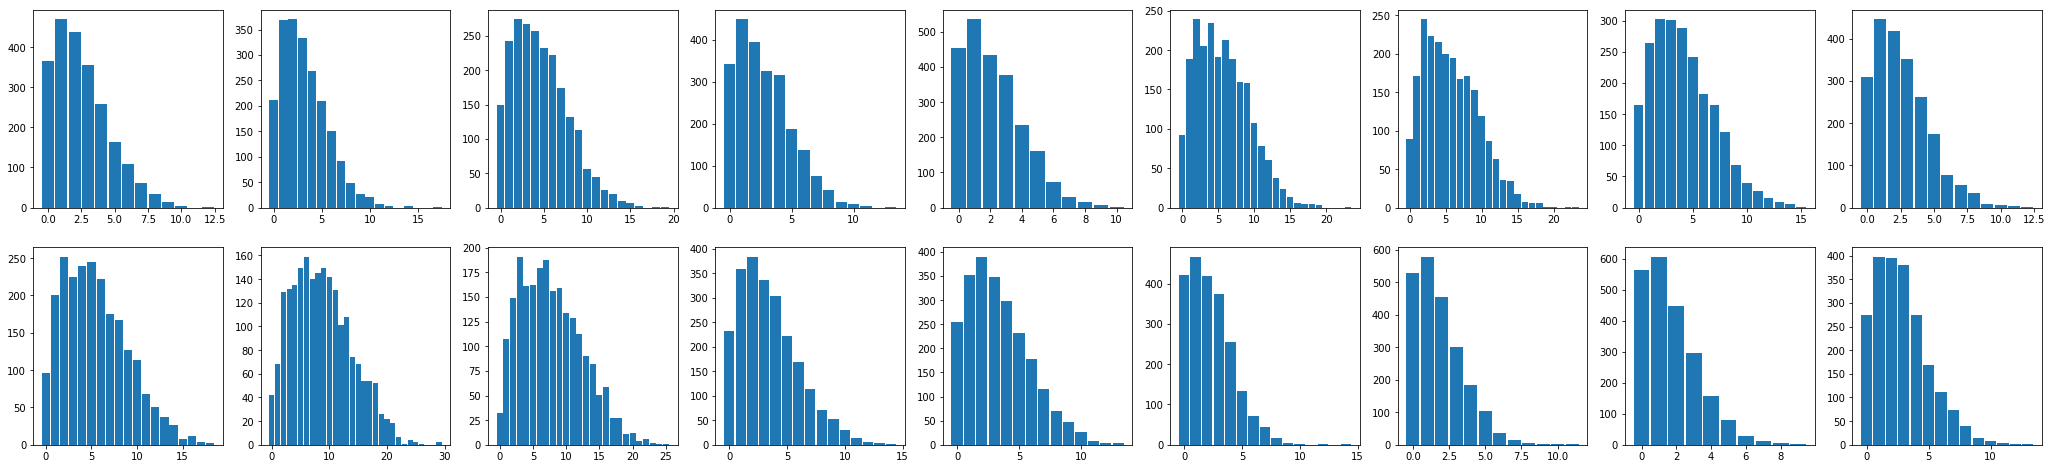

In [75]:
X_nl = torch.randn((20000,20))
fake_data = generate_fake_data(X_nl, g=500, k=9)

counts_ng = fake_data["counts_ng"]
cell_types_n = fake_data["cell_type_ids_n"]
fig = plot_few_gene_hist(cell_types_n, counts_ng[:,:2])
fig

### Package the fake data for the models

In [76]:
fake_dataset = {
    "counts" : fake_data["counts_ng"],
    "cell_type_codes" : fake_data["cell_type_ids_n"],
    "other_covariates" : fake_data["X_nl"]
}                               

# Define the initial parameters/priors for all models

In [77]:
# Define the parameter for the model prior
alpha0_loc = -6.0
alpha0_scale = 1E-2
alpha_scale = 1E-2
eps_g_low = 1E-4
eps_g_high = 1E-1

# Model

  Trace Shapes:                               
   Param Sites:                               
         alpha0        9     1 500            
  Sample Sites:                               
     cells dist                  |            
          value          20000   |            
       log_prob                  |            
cell_types dist                  |            
          value              9   |            
       log_prob                  |            
 covariate dist                  |            
          value             20   |            
       log_prob                  |            
     genes dist                  |            
          value            500   |            
       log_prob                  |            
     eps_g dist            500   |            
          value            500   |            
       log_prob            500   |            
     alpha dist     9 20   500   |            
          value     9 20   500   |            
       log_pr

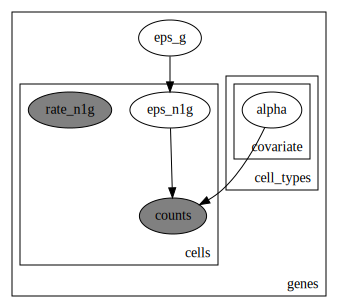

In [78]:
def model(dataset, observed: bool = True, use_covariates: bool = True):
    
    # Unpack the dataset
    counts_ng = dataset["counts"].long()
    covariates_nl = dataset['other_covariates'].float()  
    cell_type_ids_n = dataset['cell_type_codes'].long()  # ids: 0,1,...,K-1
    k = cell_type_ids_n.max().item()+1
    
    n, g = counts_ng.shape[:2]
    n, l = covariates_nl.shape[:2]
    n = cell_type_ids_n.shape[0]  
    assert isinstance(k, int) and k>0, "Got {0}".format(k)
    assert isinstance(l, int) and l>0, "Got {0}".format(l)
    assert isinstance(n, int) and n>0, "Got {0}".format(n)
    assert isinstance(g, int) and g>0, "Got {0}".format(g)
    
    if not use_covariates:
        covariates_nl = torch.zeros_like(covariates_nl)
        
    if torch.cuda.is_available(): 
        covariates_nl = covariates_nl.cuda()
        cell_type_ids_n = cell_type_ids_n.cuda()
        counts_ng = counts_ng.cuda()
    device = covariates_nl.device
    
    # Define the gene and cell plates. It make sense to subsample only gene and cells.
    cell_plate = pyro.plate("cells", size=n, dim=-3, device=device, subsample_size=None) 
    cell_types_plate = pyro.plate("cell_types", size=k, dim=-3, device=device)
    covariate_plate = pyro.plate("covariate", size=l, dim=-2, device=device)
    gene_plate = pyro.plate("genes", size=g, dim=-1, device=device, subsample_size=None) 
    
    
    with gene_plate as ind_g: 
        eps_g = pyro.sample("eps_g", dist.Uniform(low=eps_g_low, high=eps_g_high)).to(device)
        with cell_types_plate:
            alpha0_k1g = pyro.param("alpha0", 
                                    dist.Normal(loc=alpha0_loc, 
                                                scale=alpha0_scale).sample(sample_shape=[k,1,g])).to(device)
            with covariate_plate:
                alpha_klg = pyro.sample("alpha", dist.Normal(loc=0, scale=alpha_scale)).to(device)
    
    # assert eps_g.shape == torch.Size([len(ind_g)])
    # assert alpha0_k1g.shape == torch.Size([k,1,len(ind_g)]), "Got {0}".format(alpha0_k1g.shape)
    # assert alpha_klg.shape == torch.Size([k,l,len(ind_g)]), "Got {0}".format(alpha_klg.shape)
    
    with cell_plate as ind_n:
        cell_ids_sub_n = cell_type_ids_n[ind_n]
        alpha0_n1g = alpha0_k1g[cell_ids_sub_n]
        alpha_nlg = alpha_klg[cell_ids_sub_n]
        covariate_sub_nl1 = covariates_nl[cell_ids_sub_n].unsqueeze(dim=-1)
        log_mu_n1g = alpha0_n1g + torch.sum(covariate_sub_nl1 * alpha_nlg, dim=-2, keepdim=True)
        total_umi_n11 = counts_ng[ind_n].sum(dim=-1, keepdim=True).unsqueeze(dim=-1)
    
        assert alpha0_n1g.shape == torch.Size([len(ind_n), 1, len(ind_g)]), "Got {0}".format(alpha0_n1g.shape)
        assert alpha0_n1g.shape == torch.Size([len(ind_n), 1, len(ind_g)]), "Got {0}".format(alpha0_n1g.shape)
        assert total_umi_n11.shape == torch.Size([len(ind_n), 1, 1]), "Got {0}".format(total_umi_n11.shape)

        with gene_plate as ind_g: 
            eps_n1g = pyro.sample("eps_n1g", dist.Normal(loc=0, scale=eps_g))
            mu_n1g = (log_mu_n1g + eps_n1g).exp()
            rate_n1g = pyro.deterministic("rate_n1g", mu_n1g * total_umi_n11)
            
            pyro.sample("counts", dist.Poisson(rate_n1g), 
                        obs=counts_ng[ind_n, None][...,ind_g] if observed else None)
            
trace = poutine.trace(model).get_trace(fake_dataset)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

pyro.render_model(model, model_kwargs={"dataset": fake_dataset})            

In [79]:
# Everything is point estimate 
def guide_MAP(dataset, observed: bool = True, use_covariates: bool = True):
    # Unpack the dataset
    counts_ng = dataset["counts"].long()
    covariates_nl = dataset['other_covariates'].float()  
    cell_type_ids_n = dataset['cell_type_codes'].long()  # ids: 0,1,...,K-1
    k = cell_type_ids_n.max().item()+1
    
    n, g = counts_ng.shape[:2]
    n, l = covariates_nl.shape[:2]
    n = cell_type_ids_n.shape[0]  
    assert isinstance(k, int) and k>0, "Got {0}".format(k)
    assert isinstance(l, int) and l>0, "Got {0}".format(l)
    assert isinstance(n, int) and n>0, "Got {0}".format(n)
    assert isinstance(g, int) and g>0, "Got {0}".format(g)
    
    if torch.cuda.is_available(): 
        covariates_nl = covariates_nl.cuda()
        cell_type_ids_n = cell_type_ids_n.cuda()
        counts_ng = counts_ng.cuda()
    device = covariates_nl.device
    
    # Define the gene and cell plates. It make sense to subsample only gene and cells.
    cell_plate = pyro.plate("cells", size=n, dim=-3, device=device, subsample_size=None) 
    cell_types_plate = pyro.plate("cell_types", size=k, dim=-3, device=device)
    covariate_plate = pyro.plate("covariate", size=l, dim=-2, device=device)
    gene_plate = pyro.plate("genes", size=g, dim=-1, device=device, subsample_size=None) 
    
    
    eps_param_g = pyro.param(
        "eps_loc_g", 
        eps_g_low * torch.ones(g, device=device),
        constraint=constraints.interval(eps_g_low, eps_g_high))
    
    alpha_param_loc_klg = pyro.param(
        "alpha_loc", 
        torch.zeros((k,l,g), device=device))
    
    eps_param_loc_n1g = pyro.param(
        "eps_loc_n1g", 
        torch.zeros((n,1,g), device=device))
        
    with gene_plate as ind_g: 
        eps_g = pyro.sample("eps_g", dist.Delta(v=eps_param_g[ind_g]))
        with cell_types_plate:
            with covariate_plate:
                alpha_klg = pyro.sample("alpha", dist.Delta(v=alpha_param_loc_klg[...,ind_g]))
                
    
    with cell_plate as ind_n:
        with gene_plate as ind_g: 
            eps_n1g = pyro.sample("eps_n1g", dist.Delta(v=eps_param_loc_n1g[ind_n][...,ind_g]))
            
            
# Everything is point estimate except eps_n1g
def guide_eps(dataset, observed: bool = True, use_covariates: bool = True):
    # Unpack the dataset
    counts_ng = dataset["counts"].long()
    covariates_nl = dataset['other_covariates'].float()  
    cell_type_ids_n = dataset['cell_type_codes'].long()  # ids: 0,1,...,K-1
    k = cell_type_ids_n.max().item()+1
    
    n, g = counts_ng.shape[:2]
    n, l = covariates_nl.shape[:2]
    n = cell_type_ids_n.shape[0]  
    assert isinstance(k, int) and k>0, "Got {0}".format(k)
    assert isinstance(l, int) and l>0, "Got {0}".format(l)
    assert isinstance(n, int) and n>0, "Got {0}".format(n)
    assert isinstance(g, int) and g>0, "Got {0}".format(g)
    
    if torch.cuda.is_available(): 
        covariates_nl = covariates_nl.cuda()
        cell_type_ids_n = cell_type_ids_n.cuda()
        counts_ng = counts_ng.cuda()
    device = covariates_nl.device
    
    # Define the gene and cell plates. It make sense to subsample only gene and cells.
    cell_plate = pyro.plate("cells", size=n, dim=-3, device=device, subsample_size=None) 
    cell_types_plate = pyro.plate("cell_types", size=k, dim=-3, device=device)
    covariate_plate = pyro.plate("covariate", size=l, dim=-2, device=device)
    gene_plate = pyro.plate("genes", size=g, dim=-1, device=device, subsample_size=None) 
    
    eps_param_g = pyro.param(
        "eps_loc_g", 
        eps_g_low * torch.ones(g, device=device),
        constraint=constraints.interval(eps_g_low, eps_g_high))
    
    alpha_param_loc_klg = pyro.param(
        "alpha_loc", 
        torch.zeros((k,l,g), device=device))
        
    with gene_plate as ind_g: 
        eps_g = pyro.sample("eps_g", dist.Delta(v=eps_param_g[ind_g]))
        with cell_types_plate:
            with covariate_plate:
                alpha_klg = pyro.sample("alpha", dist.Delta(v=alpha_param_loc_klg[...,ind_g]))
                                            
    with cell_plate as ind_n:
        with gene_plate as ind_g: 
            eps_n1g = pyro.sample("eps_n1g", dist.Normal(loc=0, scale=eps_g[ind_g]))
            
            
# Everything is point estimate except eps_n1g, alpha
def guide_eps_alpha(dataset, observed: bool = True, use_covariates: bool = True):
    # Unpack the dataset
    counts_ng = dataset["counts"].long()
    covariates_nl = dataset['other_covariates'].float()  
    cell_type_ids_n = dataset['cell_type_codes'].long()  # ids: 0,1,...,K-1
    k = cell_type_ids_n.max().item()+1
    
    n, g = counts_ng.shape[:2]
    n, l = covariates_nl.shape[:2]
    n = cell_type_ids_n.shape[0]  
    assert isinstance(k, int) and k>0, "Got {0}".format(k)
    assert isinstance(l, int) and l>0, "Got {0}".format(l)
    assert isinstance(n, int) and n>0, "Got {0}".format(n)
    assert isinstance(g, int) and g>0, "Got {0}".format(g)
    
    if torch.cuda.is_available(): 
        covariates_nl = covariates_nl.cuda()
        cell_type_ids_n = cell_type_ids_n.cuda()
        counts_ng = counts_ng.cuda()
    device = covariates_nl.device
    
    # Define the gene and cell plates. It make sense to subsample only gene and cells.
    cell_plate = pyro.plate("cells", size=n, dim=-3, device=device, subsample_size=None) 
    cell_types_plate = pyro.plate("cell_types", size=k, dim=-3, device=device)
    covariate_plate = pyro.plate("covariate", size=l, dim=-2, device=device)
    gene_plate = pyro.plate("genes", size=g, dim=-1, device=device, subsample_size=None) 
    
    
    eps_param_g = pyro.param(
        "eps_loc_g", 
        eps_g_low * torch.ones(g, device=device),
        constraint=constraints.interval(eps_g_low, eps_g_high))
    
    alpha_param_loc_klg = pyro.param(
        "alpha_loc", 
        torch.zeros((k,l,g), device=device))
    
    alpha_param_scale_klg = pyro.param(
        "alpha_scale", 
        alpha_scale * torch.ones((k,l,g), device=device),
        constraint=constraints.positive)
        
    with gene_plate as ind_g: 
        eps_g = pyro.sample("eps_g", dist.Delta(v=eps_param_g[ind_g]))
        with cell_types_plate:
            with covariate_plate:
                alpha_klg = pyro.sample("alpha", dist.Normal(
                    loc=alpha_param_loc_klg[..., ind_g], 
                    scale=alpha_param_scale_klg[..., ind_g]))
            
    with cell_plate as ind_n:
        with gene_plate as ind_g: 
            eps_n1g = pyro.sample("eps_n1g", dist.Normal(loc=0, scale=eps_g[ind_g]))

# Train all versions 

In [112]:
def train(model, guide, model_args=[], 
          model_kargs=dict(), lr=0.005, n_steps=2500, 
          print_frequency=50, clear_param_store=True):
    if clear_param_store:
        pyro.clear_param_store()
    
    adam = pyro.optim.Adam({"lr": lr})
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    for i in range(n_steps):
        loss = svi.step(*model_args, **model_kargs)
        if i % print_frequency == 0:
            print('[iter {}]  loss: {:.4f}'.format(i, loss))

In [ ]:
filename_list, guide_list, use_covariates_list = [], [], []
for n, guide in enumerate([guide_MAP, guide_eps, guide_eps_alpha]):
    for use_cov in [True, False]:
        print()
        print()
        print("=================")
        if use_covariates:
            filename = "params_model_"+str(n)+"_COV.pt"
        else:
            filename = "params_model_"+str(n)+"_NO_COV.pt"
        filename_list.append(filename)
        guide_list.append(guide)
        use_covariates_list.append(use_cov)
        
        start_time = time.time()
        print("Starting training:", filename)
        train(model, guide, 
              model_kargs = {"dataset": fake_dataset, 
                             "observed": True, 
                             "use_covariates": use_cov}, 
              n_steps=1, #2001, 
              print_frequency=50,
              clear_param_store=True)
        delta_time = time.time()-start_time
        print("Traning time was {0:.3f} seconds".format(delta_time))
    
        print("Params")
        for name, value in pyro.get_param_store().items():
            print(name, pyro.param(name).shape)
            
        pyro.get_param_store().save(filename=filename)

# Evaluate the models (i.e. compute log_prob)

In [105]:
true_counts_ng = fake_dataset["counts"]

log_prob_list = []
for n, (file, guide, use_cov) in enumerate(zip(filename_list, guide_list, use_covariates_list)):
    
    pyro.clear_param_store()
    pyro.get_param_store().load(filename=file)
    num_samples = 10
    
    print("Predictions")
    predictive = Predictive(model, guide=guide, num_samples=num_samples,)
    samples = predictive.get_samples(fake_dataset, observed=False, use_covariates=use_covariates)
    
    # print("Q/A")
    # print("Is eps_g deterministic? --->", torch.all(samples["eps_g"][0] == samples["eps_g"][1]))
    # print("Is alpha deterministic? --->", torch.all(samples["alpha"][0] == samples["alpha"][1]))
    # print("Is eps_n1g deterministic? ->", torch.all(samples["eps_n1g"][0] == samples["eps_n1g"][1]))
    # print("Is counts deterministic? -->", torch.all(samples["counts"][0] == samples["counts"][1]))
    
    rates_ng = samples["rate_n1g"].squeeze(dim=-2)
    log_prob_ng = dist.Poisson(rate=rates_ng).log_prob(true_counts_ng)    
    log_prob_list.append(log_prob_ng)  



Starting training: params_model_0_COV.pt
[iter 0]  loss: -56722006.7926
Traning time was 1.603 seconds
Params
eps_loc_g torch.Size([500])
alpha_loc torch.Size([9, 20, 500])
eps_loc_n1g torch.Size([20000, 1, 500])
alpha0 torch.Size([9, 1, 500])
Predictions
eps_g: (2, 1, 1, 500)
alpha: (2, 9, 20, 500)
eps_n1g: (2, 20000, 1, 500)
counts: (2, 20000, 1, 500)
rate_n1g: (2, 20000, 1, 500)
Q/A
Is eps_g deterministic? ---> tensor(True)
Is alpha deterministic? ---> tensor(True)
Is eps_n1g deterministic? -> tensor(True)
Is counts deterministic? --> tensor(False)


Starting training: params_model_0_NO_COV.pt
[iter 0]  loss: -56717010.7926
Traning time was 1.464 seconds
Params
eps_loc_g torch.Size([500])
alpha_loc torch.Size([9, 20, 500])
eps_loc_n1g torch.Size([20000, 1, 500])
alpha0 torch.Size([9, 1, 500])
Predictions
eps_g: (2, 1, 1, 500)
alpha: (2, 9, 20, 500)
eps_n1g: (2, 20000, 1, 500)
counts: (2, 20000, 1, 500)
rate_n1g: (2, 20000, 1, 500)
Q/A
Is eps_g deterministic? ---> tensor(True)
Is a

### Plot the log prob distribution

In [110]:
tmp_log_prob = log_prob_dict[0]

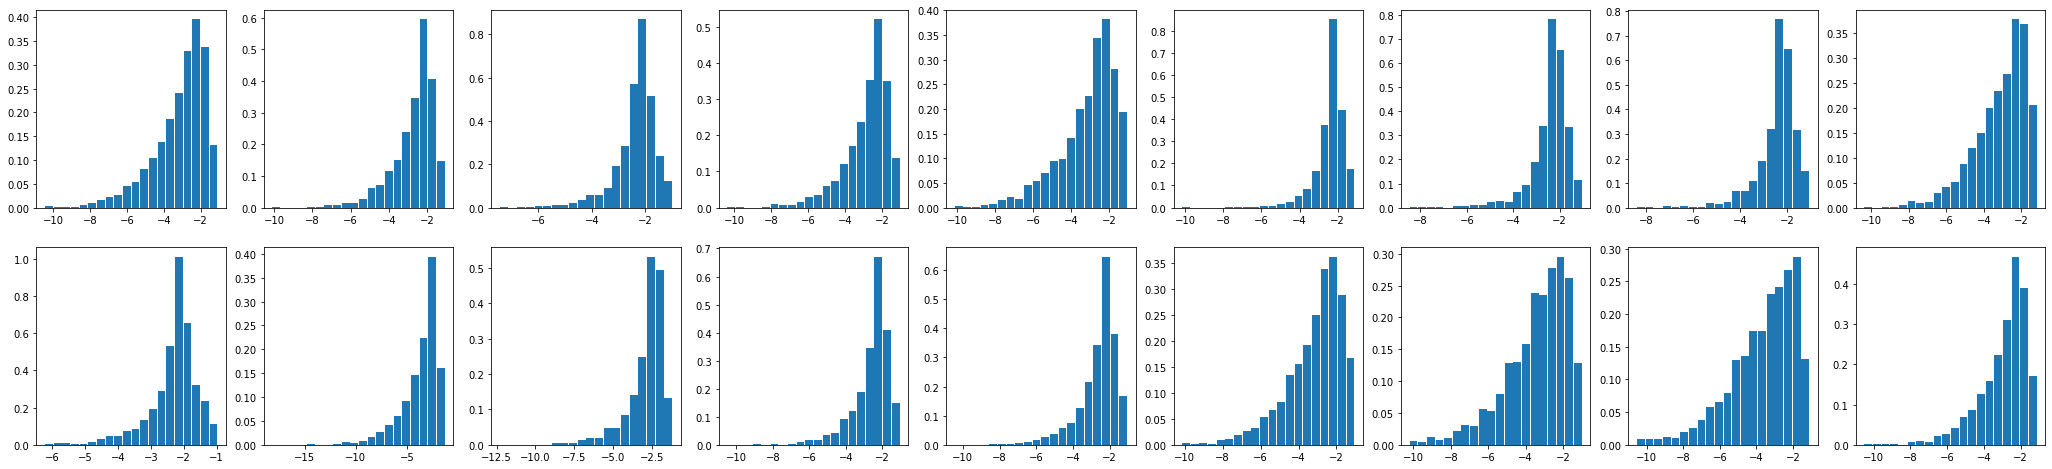

In [92]:
fig = plot_log_prob(cell_types_n, tmp_log_prob[...,:2].mean(dim=-3), ncols=4)
fig

### Compare two log_prob distributions

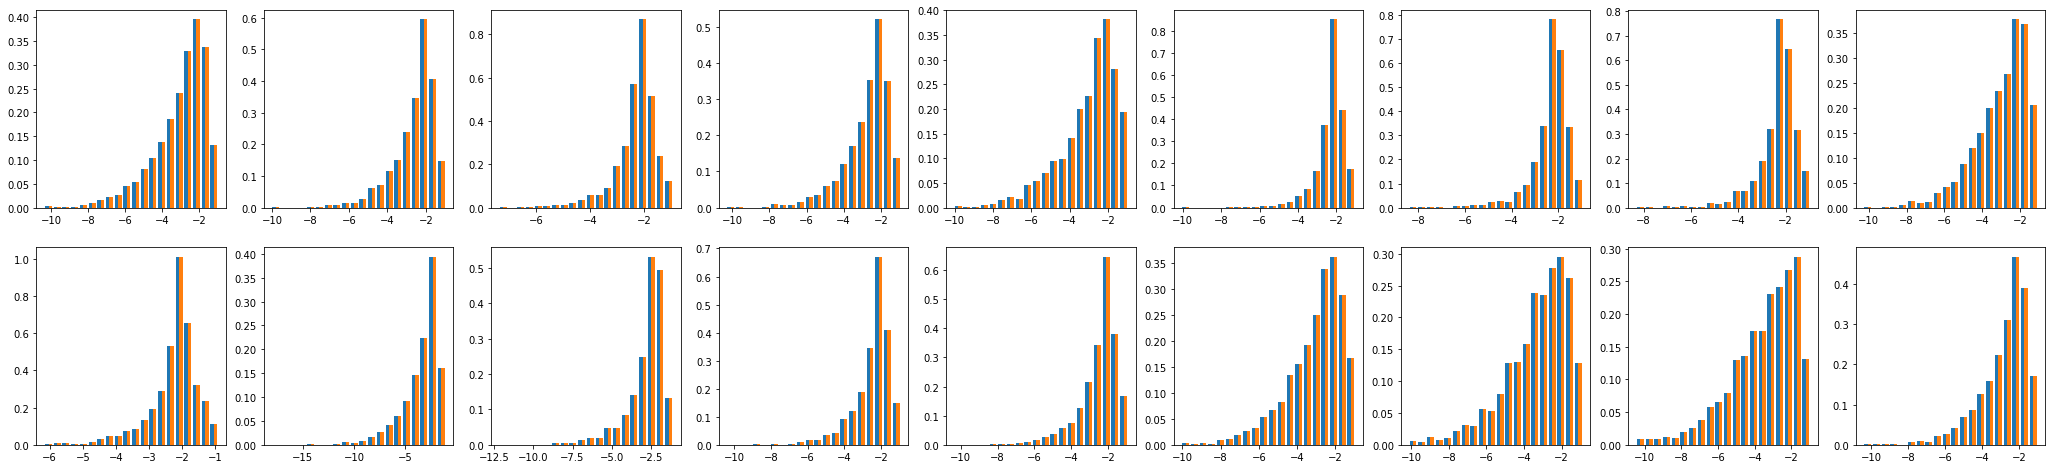

In [94]:
fig = plot_log_prob(cell_types_n, tmp_log_prob[...,:2].mean(dim=-3), tmp_log_prob[...,:2].mean(dim=-3), ncols=4) 
fig

In [ ]:
compute_log_ratio, use cki_square to translate to p-value

### Show the log_prob heat map

In [111]:
assert 1==2

AssertionError: 

# FROM HERE. DO THE SUMMARY PLOT

In [103]:
median_kg = compute_median_logprob_per_gene_and_cell_type(cell_types_n, tmp_log_prob)

torch.Size([10, 20000, 500])
torch.Size([20000, 500])


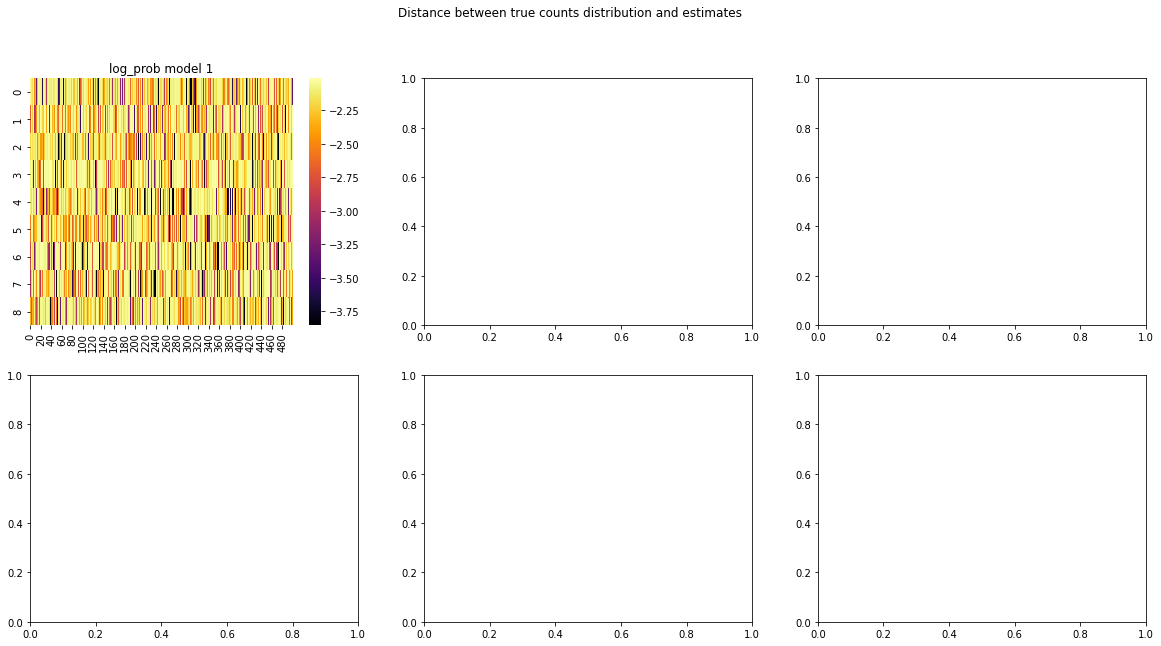

In [104]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
_ = fig.suptitle("Distance between true counts distribution and estimates")

_ = seaborn.heatmap(median_kg, cmap="inferno", robust=True, ax=axes[0,0])
_ = axes[0,0].set_title("log_prob model 1")

# FROM HERE

### Just for visualization: Plot the predicted_counts vs the real_counts

In [ ]:
pyro.get_param_store().load(filename="params_model_C.pt")
predictive_C = Predictive(model_poisson_log_normal_C, guide=guide_poisson_log_normal_C, num_samples=2,)
                        #return_sites={"counts"})
samples_C = predictive_C.get_samples(fake_dataset, observed=False)
for k, v in samples_C.items():
    print(f"{k}: {tuple(v.shape)}")

In [ ]:
assert torch.any(samples_A["counts"][0] != samples_A["counts"][1])
assert torch.any(samples_B["counts"][0] != samples_B["counts"][1])
assert torch.any(samples_C["counts"][0] != samples_C["counts"][1])

In [ ]:
cell_types_n = fake_dataset["cell_type_codes"]
true_counts_ng = fake_dataset['counts']
predA_counts_ng = samples_A["counts"][0].squeeze()
predB_counts_ng = samples_B["counts"][0].squeeze()
predC_counts_ng = samples_C["counts"][0].squeeze()

print(cell_types_n.shape, true_counts_ng.shape, predA_counts_ng.shape, predB_counts_ng.shape, predC_counts_ng.shape)

In [ ]:
fig_A = plot_few_gene_hist(cell_types_n, true_counts_ng[:,:2], predA_counts_ng[:,:2].int(), ncols=3)
fig_B = plot_few_gene_hist(cell_types_n, true_counts_ng[:,:2], predB_counts_ng[:,:2].int(), ncols=3)
fig_C = plot_few_gene_hist(cell_types_n, true_counts_ng[:,:2], predC_counts_ng[:,:2].int(), ncols=3)

In [ ]:
_ = fig_A.suptitle("MLE estimates")
fig_A

In [ ]:
_ = fig_B.suptitle("MAP estimates")
fig_B

In [ ]:
_ = fig_C.suptitle("MAP estimates. No priors on alpha0")
fig_C

## Quantify the variance 
1. at the level of distributions
2. at the level of single predictions

### at the level of distributions

In [ ]:
true_dist_kgi = compute_per_cell_type_distributions(cell_types_n, true_counts_ng)
predA_dist_kgi = compute_per_cell_type_distributions(cell_types_n, predA_counts_ng)
predB_dist_kgi = compute_per_cell_type_distributions(cell_types_n, predB_counts_ng)
predC_dist_kgi = compute_per_cell_type_distributions(cell_types_n, predC_counts_ng)

In [ ]:
L1_norm_A = L1_between_distributions(true_dist_kgi, predA_dist_kgi, normalize=True)
L1_norm_B = L1_between_distributions(true_dist_kgi, predB_dist_kgi, normalize=True)
L1_norm_C = L1_between_distributions(true_dist_kgi, predC_dist_kgi, normalize=True)

EMD_norm_A = EMD_between_distributions(true_dist_kgi, predA_dist_kgi, normalize=True)
EMD_norm_B = EMD_between_distributions(true_dist_kgi, predB_dist_kgi, normalize=True)
EMD_norm_C = EMD_between_distributions(true_dist_kgi, predC_dist_kgi, normalize=True)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
_ = fig.suptitle("Distance between true counts distribution and estimates")

_ = seaborn.heatmap(L1_norm_A, cmap="inferno", robust=True, ax=axes[0,0])
_ = seaborn.heatmap(L1_norm_B, cmap="inferno", robust=True, ax=axes[0,1])
_ = seaborn.heatmap(L1_norm_C, cmap="inferno", robust=True, ax=axes[0,2])
_ = axes[0,0].set_title("L1 wrt MLE estimates")
_ = axes[0,1].set_title("L1 wrt MAP estimates")
_ = axes[0,2].set_title("L1 wrt MAP estimates, alpha0 no prior")

_ = seaborn.heatmap(EMD_norm_A, cmap="inferno", robust=True, ax=axes[1,0])
_ = seaborn.heatmap(EMD_norm_B, cmap="inferno", robust=True, ax=axes[1,1])
_ = seaborn.heatmap(EMD_norm_C, cmap="inferno", robust=True, ax=axes[1,2])
_ = axes[1,0].set_title("EMD wrt MLE estimates")
_ = axes[1,1].set_title("EMD wrt MAP estimates")
_ = axes[1,2].set_title("EMD wrt MAP estimates, alpha0 no prior")

In [ ]:
print(L1_norm_A.median(), L1_norm_B.median(), L1_norm_C.median())
print(EMD_norm_A.median(), EMD_norm_B.median(), EMD_norm_C.median())

## At the level of single predictions

In [ ]:
from tissue_purifier.misc_utils.validation import (
    create_null_distribution,
    create_heldout_distribution
)

null_dist = create_null_distribution(
    cell_types_n=cell_types_n, 
    counts_ng=counts_ng[:,:10], 
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)   


heldout_dist = create_heldout_distribution(
    cell_types_n=cell_types_n, 
    true_counts_ng=counts_ng[:,:10], 
    pred_counts_ng=counts_ng[:,:10]+1,
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)   

### test the procedure by creating two fake distributions

In [ ]:
null_dist = create_null_distribution(
    cell_types_n=cell_types_n[-1000:], 
    counts_ng=counts_ng[-1000:,:10], 
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)     

heldout_dist = create_null_distribution(
    cell_types_n=cell_types_n[:1000], 
    counts_ng=counts_ng[:1000,:10], 
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)     

In [ ]:
gene_id = 1

x_null = null_dist["cell_type_0"][gene_id,:] / numpy.sum(null_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)
x_heldout = heldout_dist["cell_type_0"][gene_id,:] / numpy.sum(heldout_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)

barWidth=0.4
plt.bar(null_dist["boundaries"], 
        x_null, 
        width = barWidth,
       label="null")
plt.bar(heldout_dist["boundaries"]+barWidth, 
        x_heldout,
        width = barWidth,
       label="Heldout")
_ = plt.xlim([-1,20])
_ = plt.legend()
_ = plt.title("Distribution of Chi = |counts - counts|")

In [ ]:
gene_id = 6

x_null = null_dist["cell_type_0"][gene_id,:] / numpy.sum(null_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)
x_heldout = heldout_dist["cell_type_0"][gene_id,:] / numpy.sum(heldout_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)

barWidth=0.4
plt.bar(null_dist["boundaries"], 
        x_null, 
        width = barWidth,
       label="null")
plt.bar(heldout_dist["boundaries"]+barWidth, 
        x_heldout,
        width = barWidth,
       label="Heldout")
_ = plt.xlim([-1,20])
_ = plt.legend()
_ = plt.title("Distribution of Chi = |counts - counts|")

### Two-sample Kolmogorov–Smirnov test
I am asking the question if the two distribution are the same


In [ ]:
from scipy.interpolate import interp1d
from typing import NamedTuple, Union
    
class KS_test(NamedTuple):
    """ 
    Result of the KS test between two empirical distributions.
    """
    x: numpy.ndarray
    f1: numpy.ndarray
    f2: numpy.ndarray
    gap: numpy.ndarray
    ks: Union[float, numpy.ndarray]
    n1: Union[int, numpy.array]
    n2: Union[int, numpy.array]
        

def compute_pvalue_from_ks(ks_test: KS_test) -> numpy.ndarray:
    """
    Compute the p-value using the asymptotic formula 
    see. https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
    """
    n1 = ks_test.n1
    n2 = ks_test.n2
    D = ks_test.ks
    tmp = (2 * D * D * n1 * n2) / (n1 + n2)
    p = 2 * numpy.exp(-tmp)
    return p

    
def compute_KS_test(x1, histo1, x2, histo2) -> KS_test:
    
    # (empirical) cumulative distribution and size of sample
    F1_tmp = histo1.cumsum(axis=-1) # shape (genes, bins)
    n1 = F1_tmp[...,-1:]            # shape (genes, 1)
    F1 = F1_tmp / n1                # shape (genes, bins)
    
    # (empirical) cumulative distribution and size of sample
    F2_tmp = histo2.cumsum(axis=-1) 
    n2 = F2_tmp[..., -1:]
    F2 = F2_tmp / n2
    
    # Interpolate sample 1 on the spacing of sample 2 
    f_interp = interp1d(x1, F1, axis=-1, fill_value=(0.0, 1.0))
    F1_new = f_interp(x2)
    
    # Comute the maximum gap between empirical cumulative distributions
    gap = numpy.abs(F1_new - F2)
    ks = numpy.max(gap, axis=-1, keepdims=True)
    
    return KS_test(x=x2, f1=F1_new, f2=F2, n1=n1, n2=n2, gap=gap, ks=ks)


key_cell_types = []
for key in null_dist.keys():
    if key.startswith("cell_type_"):
        key_cell_types.append(key)
    

#df = pandas.DataFrame()
for k in key_cell_types:        
    
    ks_test_tmp = compute_KS_test(
        x1=null_dist["boundaries"], 
        histo1=null_dist["cell_type_0"], 
        x2=heldout_dist["boundaries"], 
        histo2=heldout_dist["cell_type_0"])
    
    p_values_tmp = compute_pvalue_from_ks(ks_test_tmp)
    
    
    
#    dfdf = pd.DataFrame(columns=["firstname", "lastname"])
#df = df.append({
#     "firstname": "John",
#     "lastname":  "Johny"
#      }, ignore_index=True)
    
    dict_tmp = {'ks' : ks_test_tmp.ks, 'p_value': p_values_tmp, 'cell_type': [k]*len(p_values_tmp)}

In [ ]:
ncol = 4
nmax = len(ks_test.ks)
nrow = int(numpy.ceil(float(nmax) / ncol))

fig, axes = plt.subplots(ncols=ncol, nrows=nrow, figsize=(4*ncol, 4*nrow))
for n in range(nmax):
    r,c = n // ncol, n % ncol
    axes[r,c].plot(ks_test.x, ks_test.f1[n,:])
    axes[r,c].plot(ks_test.x, ks_test.f2[n,:])
    axes[r,c].plot(ks_test.x, ks_test.gap[n,:])
    axes[r,c].set_xlim([0,20])
    axes[r,c].set_title("ks={0:.3} -> pvalue={1:.3}".format(ks_test.ks[n].item(), p_values[n].item()))